In [1]:
# Bibs gerais
import gc
import numpy as np
import pandas as pd
import seaborn as sns

# Abordagens 1 e 4
import re
import unicodedata
from tkinter.tix import TCL_WINDOW_EVENTS
from sklearn.feature_extraction.text import TfidfVectorizer

from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from lightgbm import log_evaluation
from tqdm import tqdm

# Abordagens 2 e 3
import torch
from datasets import Dataset
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import Trainer
from transformers import AutoModel

# Carregando arquivos
x_sub = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv',index_col='id')
y_sub = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/sample_submission.csv',index_col='id')
train = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv',index_col='id')

train.head()

,premise,hypothesis,lang_abv,language,label
id,,,,,
5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [2]:
# Instalando e importando tradução
!pip install googletrans==3.1.0a0

from googletrans import Translator

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=a49bc449017894b2290687be627840b0cb68c3ef6296335e34078c1be32b50c8
  Stored in directory: /root/.cache/pip/wheels/61/f7/ef/4d5c03c448eb8583bc063caca7e8802d8801af40c65e9b8022
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.

# Observando o dataset

In [3]:
train.isnull().sum()

premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [4]:
train.describe()

,label
count,12120.000000
mean,0.990759
std,0.824523
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


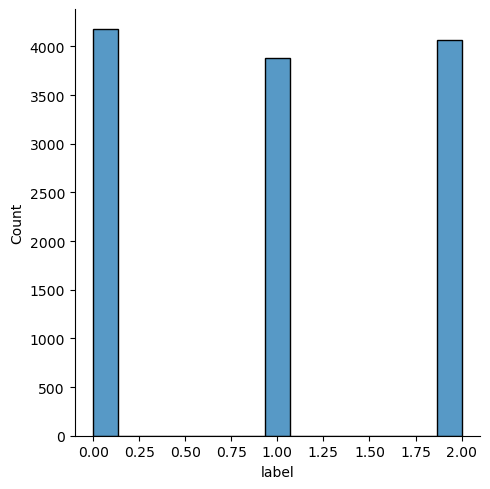

In [5]:
sns.displot(train.label);

In [6]:
print(len(train.language.unique()))
print(train.language.value_counts())

15
English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: language, dtype: int64


In [7]:
def count_values_by_category(df, count_column_name, category_column_name):
    """
    Receives a pandas dataframe, a column with categorical values and a column
    to be counted, and returns a new dataframe with the count of occurrences of
    each count_column value for each category_column value.
    """
    # Group the DataFrame by the category_column and count the values in the count_column
    counts_df = df.groupby(category_column_name)[count_column_name].value_counts().unstack(fill_value=0)
    
    return counts_df

counts_df = count_values_by_category(train, 'label', 'lang_abv')
counts_df

label,0,1,2
lang_abv,,,
ar,124,129,148
bg,123,111,108
de,108,116,127
el,120,127,125
en,2427,2166,2277
es,118,112,136
fr,133,129,128
hi,125,112,137
ru,132,124,120


# Abordagem 1: tradução

Copiando para processar

In [8]:
trainC = train.copy()

In [9]:
# Initialize the translator
#translator = Translator()

# Define a function to translate text to English
def translate_to_english(text, lang):
    if lang.lower() == 'en':
        # Return the original text for English rows
        return text
    elif lang.lower() == 'zh':
        # Translate Chinese rows to English
        return translator.translate(text, dest='en').text
    else:
        # Translate non-English rows to English
        return translator.translate(text, src=lang, dest='en').text

#tqdm.pandas()

#trainC['premise'] = trainC.progress_apply(lambda row: translate_to_english(row['premise'],
                                                                           #row['lang_abv']), axis=1)
#trainC['hypothesis'] = trainC.progress_apply(lambda row: translate_to_english(row['hypothesis'],
                                                                              #row['lang_abv']), axis=1)

Funções para remoção de complexidade

In [10]:
def remove_url_func(text):
    '''
    Removes URL addresses from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without URL addresses
    ''' 
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_punctuation_func(text):
    '''
    Removes all punctuation from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without punctuations
    '''
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

def remove_extra_whitespaces_func(text):
    '''
    Removes extra whitespaces from a string, if present

    Args:
        text (str): String to which the function is to be applied, string

    Returns:
        Clean string without extra whitespaces
    ''' 
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

def remove_accented_chars_func(text):
    '''
    Removes all accented characters from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without accented characters
    '''
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [11]:
trainC['premise'] = trainC.premise.apply(str.lower)
trainC['premise'] = trainC.premise.apply(remove_url_func)
trainC['premise'] = trainC.premise.apply(remove_punctuation_func)
trainC['premise'] = trainC.premise.apply(remove_accented_chars_func)
trainC['premise'] = trainC.premise.apply(remove_extra_whitespaces_func)

trainC['hypothesis'] = trainC.hypothesis.apply(str.lower)
trainC['hypothesis'] = trainC.hypothesis.apply(remove_url_func)
trainC['hypothesis'] = trainC.hypothesis.apply(remove_punctuation_func)
trainC['hypothesis'] = trainC.hypothesis.apply(remove_accented_chars_func)
trainC['hypothesis'] = trainC.hypothesis.apply(remove_extra_whitespaces_func)

Aplicando TFIDF e subtraindo as colunas de texto

In [12]:
def tfidf_transform(df, col1, col2):
    """
    Fit a TF-IDF transform on two columns of a pandas dataframe,
    and return the TF-IDF dictionary and the difference between
    the transformed columns.
    
    :param df: pandas dataframe
    :param col1: name of the first column to transform
    :param col2: name of the second column to transform
    :return: tuple containing the TF-IDF dictionary and the difference
             between the transformed columns
    """
    # Concatenate the two columns into a single Series
    text = df[col1].str.cat(df[col2], sep=' ')
    
    # Fit the TF-IDF transform
    tfidf = TfidfVectorizer()
    tfidf.fit(text)
    
    # Transform the individual columns
    col1_tfidf = tfidf.transform(df[col1])
    col2_tfidf = tfidf.transform(df[col2])
    
    # Calculate the difference between the transformed columns
    X = col1_tfidf - col2_tfidf
    
    return tfidf, X

# Apply the function to the dataframe
#tfidf, X = tfidf_transform(trainC, 'premise', 'hypothesis')

Aplicando modelo

In [13]:
#y = trainC['label']
#Xpd = pd.DataFrame(X.toarray())

#X_train, X_val, y_train, y_val = train_test_split(Xpd, y, test_size=0.15, random_state=42)

# Create the LGBMClassifier model
#model = LGBMClassifier(objective='multiclass', num_class=3, n_jobs=-1, random_state=42)

# Define the early stopping criteria
#eval_set = [(X_val, y_val)]
#early_stopping_rounds = 10

# Train the model with early stopping
#model.fit(X_train, y_train,
          #callbacks=[early_stopping(100), log_evaluation(100)],
          #eval_metric='logloss',
          #eval_set=eval_set)

## Gerando submissão

In [14]:
x_subC = x_sub.copy()

In [15]:
#tqdm.pandas(desc="Translation Progress")
#x_subC['premise'] = x_subC.progress_apply(lambda row: translate_to_english(row['premise'],
                                                                           #row['lang_abv']), axis=1)
#x_subC['hypothesis'] = x_subC.progress_apply(lambda row: translate_to_english(row['hypothesis'],
                                                                              #row['lang_abv']), axis=1)

In [16]:
x_subC['premise'] = x_subC.premise.apply(str.lower)
x_subC['premise'] = x_subC.premise.apply(remove_url_func)
x_subC['premise'] = x_subC.premise.apply(remove_punctuation_func)
x_subC['premise'] = x_subC.premise.apply(remove_accented_chars_func)
x_subC['premise'] = x_subC.premise.apply(remove_extra_whitespaces_func)

x_subC['hypothesis'] = x_subC.hypothesis.apply(str.lower)
x_subC['hypothesis'] = x_subC.hypothesis.apply(remove_url_func)
x_subC['hypothesis'] = x_subC.hypothesis.apply(remove_punctuation_func)
x_subC['hypothesis'] = x_subC.hypothesis.apply(remove_accented_chars_func)
x_subC['hypothesis'] = x_subC.hypothesis.apply(remove_extra_whitespaces_func)

In [17]:
#x1 = tfidf.transform(x_subC['premise'])
#x2 = tfidf.transform(x_subC['hypothesis'])

#Xsub = x1 - x2
#Xsub = pd.DataFrame(Xsub.toarray())

In [18]:
#ID = x_sub.index.values
#prevt = model.predict(Xsub)
#submission = pd.DataFrame({'id' : ID,'prediction' : prevt })
#submission.to_csv('submission.csv',index = False)
#submission.describe()

# Abordagem 2: Pré treinado sem alteração

In [19]:
#checkpoint = "symanto/xlm-roberta-base-snli-mnli-anli-xnli"
#tokenizer = AutoTokenizer.from_pretrained(checkpoint)
#model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [20]:
#trainer = Trainer(model, tokenizer=tokenizer)

In [21]:
#train_ds = Dataset.from_pandas(train)
#train_ds

In [22]:
def tokenize(batch):
    return tokenizer(batch['premise'], batch['hypothesis'])

In [23]:
#train_ds = train_ds.map(tokenize, batched=True, remove_columns=list(train.columns))
#train_ds

In [24]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = AutoModel.from_pretrained(checkpoint).to(device)

Geração da Submissão

In [25]:
#test_ds = Dataset.from_pandas(x_sub)
#test_ds = test_ds.map(tokenize, batched=True, remove_columns=list(x_sub.columns))
#preds_test = trainer.predict(test_ds).predictions.argmax(axis=-1)
#preds_test.shape

In [26]:
#submission = pd.DataFrame({'id': ID, 'prediction': preds_test})
#submission

In [27]:
#submission.to_csv('submission.csv', index=False)

# Abordagem 3: Pré-treinado com tradução

In [28]:
#checkpoint = "symanto/xlm-roberta-base-snli-mnli-anli-xnli"
#tokenizer = AutoTokenizer.from_pretrained(checkpoint)
#model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [29]:
#trainer = Trainer(model, tokenizer=tokenizer)

In [30]:
#train_ds = Dataset.from_pandas(train)
#train_ds

In [31]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = AutoModel.from_pretrained(checkpoint).to(device)

## Traduzindo e gerando submissão

In [32]:
#x_subC = x_sub.copy()

#tqdm.pandas(desc="Translation Progress")
#x_subC['premise'] = x_subC.progress_apply(lambda row: translate_to_english(row['premise'],
                                                                           #row['lang_abv']), axis=1)
#x_subC['hypothesis'] = x_subC.progress_apply(lambda row: translate_to_english(row['hypothesis'],
                                                                              #row['lang_abv']), axis=1)

In [33]:
#x_subC['lang_abv'] = 'en'
#x_subC['language'] = 'English'

In [34]:
#test_ds = Dataset.from_pandas(x_subC)
#test_ds = test_ds.map(tokenize, batched=True, remove_columns=list(x_sub.columns))
#preds_test = trainer.predict(test_ds).predictions.argmax(axis=-1)
#preds_test.shape

In [35]:
#submission = pd.DataFrame({'id': ID, 'prediction': preds_test})
#submission

In [36]:
#submission.to_csv('submission.csv', index=False)

# Abordagem 4: Tokenizador pré-treinado, modelo sem pré-treino

In [37]:
checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def convert_id(example):
    example["id"] = int(example["id"], 16)
    return example

def tokenize(batch, max_length=225):
    return tokenizer(
        batch['premise'], 
        batch['hypothesis'], 
        padding=True,#'max_length',
        truncation=True,
        max_length=max_length
    )

cols_to_remove = list(trainC.columns)
cols_to_remove.remove('label')

train_ds = Dataset.from_pandas(train)
train_ds = train_ds.map(tokenize, batched=True, batch_size=None, remove_columns=cols_to_remove)
train_ds = train_ds.map(convert_id)
train_ds.set_format("torch")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/12120 [00:00<?, ?ex/s]

In [38]:
# Load the pre-trained BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(checkpoint).to(device)
model_name = 'bert-base-uncased'
#model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU:
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states:
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vectors for the '<s>' token:
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

train_ds = train_ds.map(extract_hidden_states, batched=True, batch_size=128)
train_ds

  0%|          | 0/95 [00:00<?, ?ba/s]

Dataset({
    features: ['label', 'id', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 12120
})

In [40]:
X = np.array(train_ds['hidden_state'])
y = np.array(train_ds['label'])
X.shape, y.shape

((12120, 768), (12120,))

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Create the LGBMClassifier model
modelo = LGBMClassifier(objective='multiclass', num_class=3, n_jobs=-1, random_state=42)

# Define the early stopping criteria
eval_set = [(X_val, y_val)]
early_stopping_rounds = 10

# Train the model with early stopping
modelo.fit(X_train, y_train,
           callbacks=[early_stopping(100), log_evaluation(100)],
           eval_metric='logloss',
           eval_set=eval_set)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.13343
Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 1.09203


LGBMClassifier(num_class=3, objective='multiclass', random_state=42)

## Gerando submissão

In [42]:
sub = Dataset.from_pandas(x_sub)
sub = sub.map(tokenize, batched=True, batch_size=None, remove_columns=cols_to_remove)
sub = sub.map(convert_id)
sub.set_format("torch")

sub = sub.map(extract_hidden_states, batched=True, batch_size=128)
sub

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5195 [00:00<?, ?ex/s]

  0%|          | 0/41 [00:00<?, ?ba/s]

Dataset({
    features: ['id', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 5195
})

In [43]:
Xsub = np.array(sub['hidden_state'])
Xsub.shape

(5195, 768)

In [44]:
ID = x_sub.index.values
prevt = modelo.predict(Xsub)
submission = pd.DataFrame({'id' : ID,'prediction' : prevt })
submission.to_csv('submission.csv',index = False)
submission.describe()

,prediction
count,5195.000000
mean,0.947257
std,0.856643
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000
